In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [22]:

df = pd.read_csv("../preprocessed/ETH.csv", parse_dates=['Date'],
                date_format='%Y-%m-%d')

#df['Date'] = pd.to_datetime(df['Date'].str.replace(' UTC+0', ''))
df = df.set_index('Date').sort_index()

In [28]:
df


,Price,Volume,Market_cap,Return,Log_Return,MA_7,Vol_7,MA_14,Vol_14,MA_30,Vol_30,MA_90,Vol_90,LogPrice
Date,,,,,,,,,,,,,,
2015-08-08,1.330750,3.680700e+05,8.033948e+07,NaN,NaN,1.330750,NaN,1.330750,NaN,1.330750,NaN,1.330750,NaN,0.285743
2015-08-10,0.687586,4.004641e+05,4.155631e+07,-0.483310,-0.660311,1.009168,NaN,1.009168,NaN,1.009168,NaN,1.009168,NaN,-0.374569
2015-08-11,1.067379,1.518998e+06,6.453901e+07,0.552358,0.439775,1.028572,0.732327,1.028572,0.732327,1.028572,0.732327,1.028572,0.732327,0.065206
2015-08-12,1.256613,2.073893e+06,7.601326e+07,0.177289,0.163214,1.085582,0.524353,1.085582,0.524353,1.085582,0.524353,1.085582,0.524353,0.228420
2015-08-13,1.825395,4.380143e+06,1.104688e+08,0.452631,0.373376,1.233545,0.466496,1.233545,0.466496,1.233545,0.466496,1.233545,0.466496,0.601797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-17,2741.253325,1.000657e+10,3.304725e+11,0.030112,0.029667,2691.514924,0.028958,2686.309670,0.027503,2954.799266,0.029776,3337.897287,0.034691,7.916171
2025-02-18,2668.889805,1.077994e+10,3.217527e+11,-0.026398,-0.026753,2700.840800,0.029713,2681.233888,0.025238,2936.821904,0.029698,3333.405914,0.034774,7.889418
2025-02-19,2716.204376,6.641387e+09,3.274633e+11,0.017728,0.017573,2697.702454,0.022515,2675.922064,0.025193,2918.042631,0.029563,3326.253072,0.033355,7.906991


In [24]:
df["LogPrice"] = np.log(df["Price"])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     34.47
Date:                Sun, 27 Apr 2025   Prob (F-statistic):           2.22e-07
Time:                        22:32:27   Log-Likelihood:                 90.460
No. Observations:                  60   AIC:                            -176.9
Df Residuals:                      58   BIC:                            -172.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2365      0.014    592.712      0.0

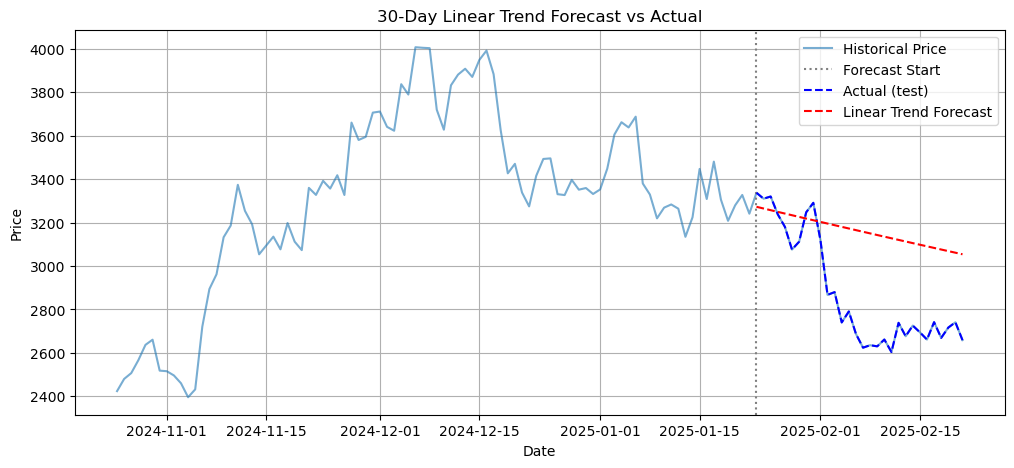

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1) Prepare your DataFrame: ensure LogPrice exists and index is datetime
df['LogPrice'] = np.log(df['Price'])

# 2) Define your forecast horizon
horizon = 30

# 3) Split train/test
train = df['LogPrice'].iloc[-horizon * 3:-horizon]
test  = df['LogPrice'].iloc[-horizon:]  # these are log‐prices

# 4) Encode time for training
t0 = train.index.min().toordinal()
t_train = (train.index.map(pd.Timestamp.toordinal) - t0) / 365
X_train = sm.add_constant(t_train)

# 5) Fit the linear trend model
model = sm.OLS(train.values, X_train).fit()
print(model.summary())

# 6) Forecast on the test dates
future_dates = test.index
t_future = (future_dates.map(pd.Timestamp.toordinal) - t0) / 365
Xf = sm.add_constant(t_future)
log_pred = model.predict(Xf)
pred_price = np.exp(log_pred)                

# 7) Gather actual prices
actual_price = df['Price'].loc[future_dates]

# 8) Compute accuracy metrics
mape = np.mean(np.abs((actual_price - pred_price)/actual_price)) * 100
rmse = np.sqrt(mean_squared_error(actual_price, pred_price))
print(f"MAPE over last {horizon} days: {mape:.2f}%")
print(f"RMSE over last {horizon} days: {rmse:.2f}")

# 9) Plot full history + test vs forecast
plt.figure(figsize=(12,5))
#plt.plot(df.index, df['Price'],    label='Historical Price', alpha=0.6)
plt.plot(df.index[-120:], df['Price'].iloc[-120:], label='Historical Price', alpha=0.6)
plt.axvline(future_dates[0], color='gray', linestyle=':', label='Forecast Start')

# Overlay actual last 30 days
plt.plot(future_dates, actual_price, 'b--', label='Actual (test)')

# Overlay forecast
plt.plot(future_dates, pred_price, 'r--', label='Linear Trend Forecast')

plt.title(f"{horizon}-Day Linear Trend Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:               LogPrice   No. Observations:                 3456
Model:                 ARIMA(1, 1, 1)   Log Likelihood                5114.041
Date:                Sun, 27 Apr 2025   AIC                         -10220.082
Time:                        22:32:11   BIC                         -10195.491
Sample:                    08-08-2015   HQIC                        -10211.300
                         - 01-22-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0022      0.001      2.414      0.016       0.000       0.004
ar.L1         -0.5090      0.151     -3.378      0.001      -0.804      -0.214
ma.L1          0.4696      0.1

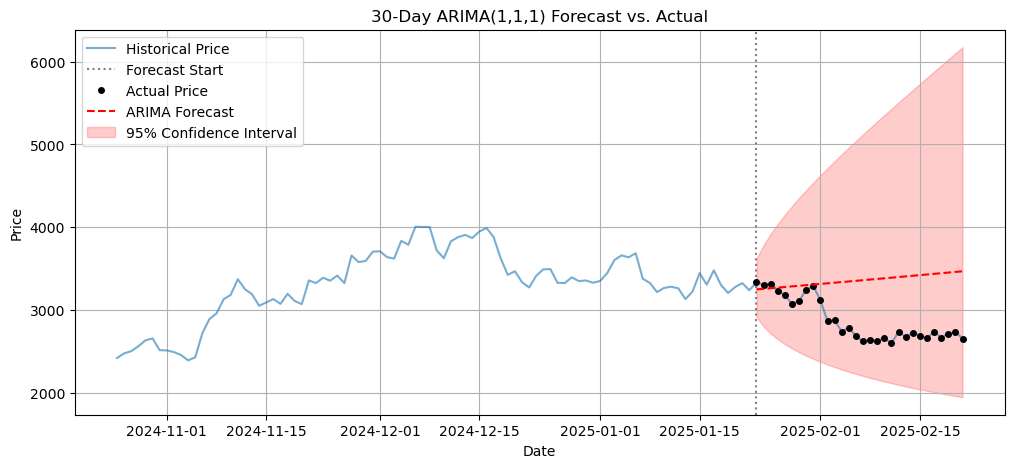

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Load and prepare data
file_path = '../resampled/ETH.csv'
df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date').sort_index()
df['LogPrice'] = np.log(df['Price'])

# Configure forecast parameters
horizon = 30  # Days to forecast
lookback = 120  # Days of history to show in plot
train = df['LogPrice'].iloc[:-horizon]
test = df['LogPrice'].iloc[-horizon:]

model = ARIMA(train, order=(1,1,1), trend='t').fit()
print("\nARIMA Model Summary:")
print(model.summary())

# Generate forecasts and confidence intervals
forecast = model.get_forecast(steps=horizon)
fc_log = forecast.predicted_mean
ci_log = forecast.conf_int()

# Transform predictions back to price scale
fc_price = np.exp(fc_log)
ci_lower = np.exp(ci_log.iloc[:, 0])
ci_upper = np.exp(ci_log.iloc[:, 1])
actual_price = df['Price'].iloc[-horizon:]

# Calculate error metrics
mape = mean_absolute_percentage_error(actual_price, fc_price) * 100
rmse = np.sqrt(mean_squared_error(actual_price, fc_price))
print(f"\nForecast Accuracy Metrics:")
print(f"MAPE (30-day): {mape:.2f}%")
print(f"RMSE (30-day): {rmse:.2f}")

# Visualize results
plt.figure(figsize=(12,5))
plt.plot(df.index[-lookback:], df['Price'].iloc[-lookback:], 
         label='Historical Price', alpha=0.6)
plt.axvline(test.index[0], color='gray', linestyle=':', 
            label='Forecast Start')
plt.plot(test.index, actual_price, 'ko', 
         label='Actual Price', markersize=4)
plt.plot(test.index, fc_price, 'r--', 
         label='ARIMA Forecast')
plt.fill_between(test.index, ci_lower, ci_upper, 
                 color='r', alpha=0.2, label='95% Confidence Interval')

plt.title("30-Day ARIMA(1,1,1) Forecast vs. Actual")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     4.395
Date:                Sun, 27 Apr 2025   Prob (F-statistic):             0.0373
Time:                        22:40:14   Log-Likelihood:                -91.892
No. Observations:                 206   AIC:                             187.8
Df Residuals:                     204   BIC:                             194.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.5984      0.053    144.078      0.0

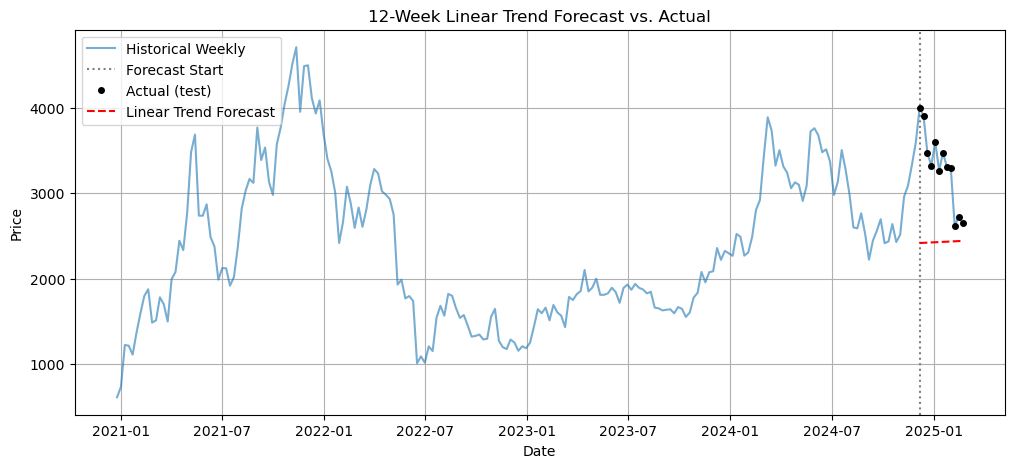

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Load your resampled daily data and aggregate to weekly (Friday close)
df = pd.read_csv('../resampled/Lido.csv', parse_dates=['Date'], index_col='Date').sort_index()
weekly = df['Price'].resample('W-FRI').last().dropna()

# 2. Work in log-space
weekly_log = np.log(weekly)

# 3. Define forecast horizon (in weeks)
horizon = 12

# 4. Split train/test
train = weekly_log.iloc[:-horizon]
test = weekly_log.iloc[-horizon:]

# 5. Encode time in years since start of train
t0 = train.index.min().toordinal()
t_train = (train.index.map(pd.Timestamp.toordinal) - t0) / 365
X_train = sm.add_constant(t_train)

# 6. Fit linear OLS on log-price
model = sm.OLS(train.values, X_train).fit()
print(model.summary())  # slope β is annualized continuous growth rate

# 7. Forecast next 12 weeks
future_dates = test.index
t_future = (future_dates.map(pd.Timestamp.toordinal) - t0) / 365
Xf = sm.add_constant(t_future)
log_fc = model.predict(Xf)
price_fc = np.exp(log_fc)

# 8. Calculate accuracy metrics
actual = weekly.loc[future_dates]
mape = np.mean(np.abs((actual - price_fc) / actual)) * 100
rmse = np.sqrt(mean_squared_error(actual, price_fc))
print(f"\nForecast Accuracy Metrics:")
print(f"Weekly Linear Trend MAPE: {mape:.2f}%")
print(f"Weekly Linear Trend RMSE: {rmse:.2f}")

# 9. Plot history + actual vs. forecast
plt.figure(figsize=(12,5))
plt.plot(weekly.index, weekly, label='Historical Weekly', alpha=0.6)
plt.axvline(future_dates[0], color='gray', linestyle=':', label='Forecast Start')
plt.plot(future_dates, actual, 'ko', label='Actual (test)', markersize=4)
plt.plot(future_dates, price_fc, 'r--', label='Linear Trend Forecast')
plt.title(f"{horizon}-Week Linear Trend Forecast vs. Actual")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()
